# **Importing Libraries**

In [ ]:
#Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.dates as md
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn import preprocessing
from keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import time

**Algorithm implemented :**

* Cluster based anomaly detection (K-mean)
* Repartition of data into categories then Gaussian Enveloppe on each categories separately
*Isolation Forest


In [ ]:
# some function for later

# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

In [ ]:
path = '/content/temperature_device_failure.csv'

In [ ]:
df = pd.read_csv(path)

In [ ]:
df.head(10)

,timestamp,value
0,7/4/2013 0:00,69.880835
1,7/4/2013 1:00,71.220227
2,7/4/2013 2:00,70.877805
3,7/4/2013 3:00,68.959400
4,7/4/2013 4:00,69.283551
5,7/4/2013 5:00,70.060966
6,7/4/2013 6:00,69.279765
7,7/4/2013 7:00,69.369608
8,7/4/2013 8:00,69.166714
9,7/4/2013 9:00,68.986083


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


In [ ]:
print(df['value'].mean())

71.24243270828815


# **EDA**

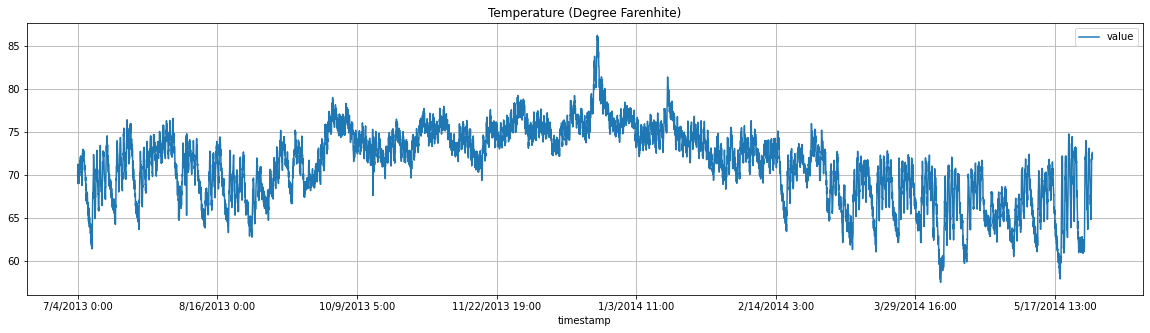

In [ ]:
#Visualize the data
figsize=(20,5)
df.plot(x='timestamp', y='value', figsize=figsize, title='Temperature (Degree Farenhite)');
plt.grid();
plt.show();

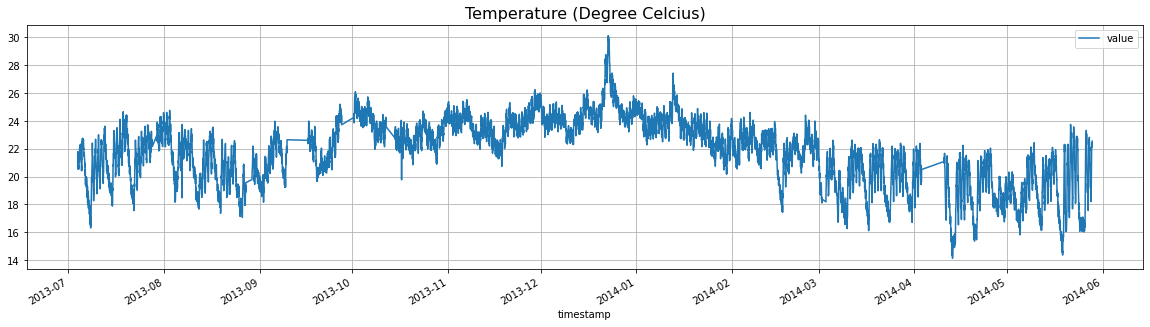

In [ ]:
#Changing the type of timestamp column for visualization
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5/9
df.plot(x='timestamp', y='value', figsize=figsize);
plt.title('Temperature (Degree Celcius)', fontsize=16);
plt.grid();
plt.show();

# **Feature engineering**

In [ ]:
#Formating the data into required format
df['hours'] = df['timestamp'].dt.hour
# the hours and if it's night or day (7:00-22:00)
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [ ]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  


In [ ]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']
a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

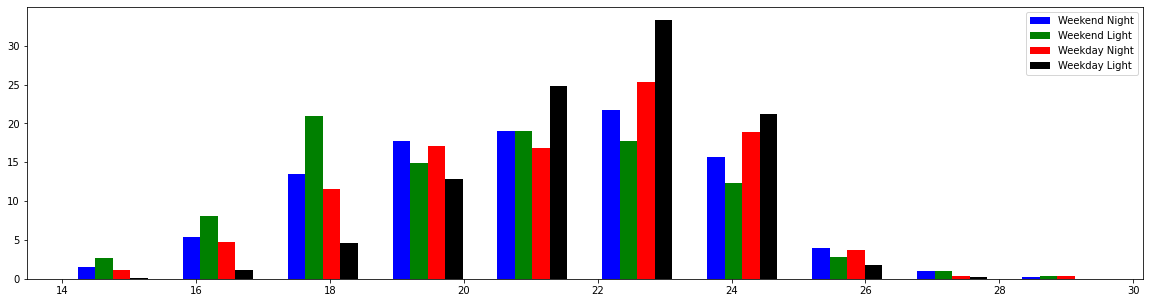

In [ ]:
#Visualizing the formatted data
figsize=(20,5)
fig, ax = plt.subplots(figsize=figsize)
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)
width = (a_bins[1] - a_bins[0])/6
ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Weekend Night')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Weekend Light')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Weekday Night')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='Weekday Light')
plt.legend()
plt.show()

# **Models**

## **KMeans and PCA**

Use for collective anomalies (unordered).
We group together the usual combination of features. The points that are far from the cluster are points with usual combination of features.We consider those points as anomalies.

In [ ]:
# Take useful feature and standardize them
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

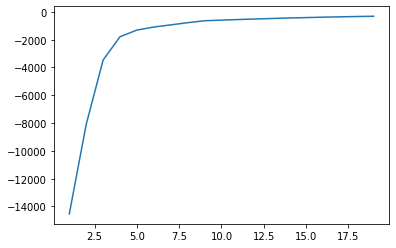

In [ ]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [ ]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

0     668
4     596
1     587
10    585
13    575
7     540
14    518
3     512
8     490
5     418
2     401
11    354
6     350
9     339
12    334
Name: cluster, dtype: int64

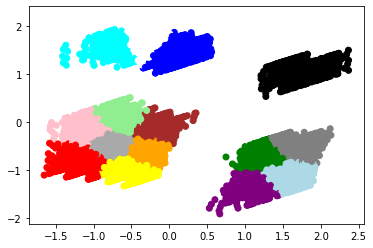

In [ ]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [ ]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


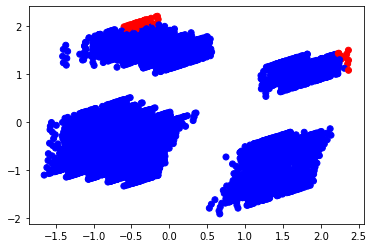

In [ ]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

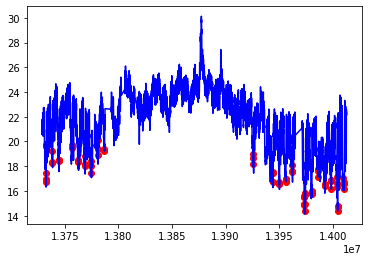

In [ ]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


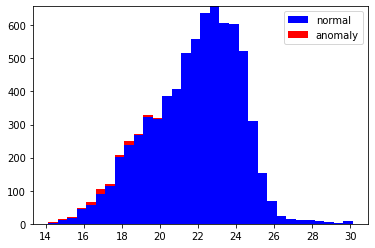

In [ ]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Cluster method detects the low temperature around the end of record as unusually low. It doesn't detect the highest temperature pic.

## **Categories + Gaussian**

**Use for contextual data and collective anomalies (unordered).**

We will separate data by (what we think of) important categories. Or we can separate data based on different cluster. Then we find outliers (gaussian repartition, unimodal) by categories independently.

In [ ]:
# creation of 4 differents data set based on categories defined before
df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']

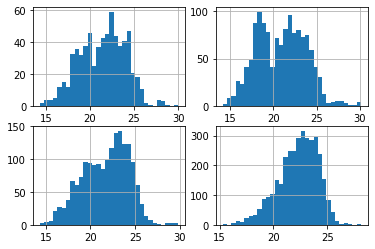

In [ ]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [ ]:
# apply ellipticEnvelope(gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


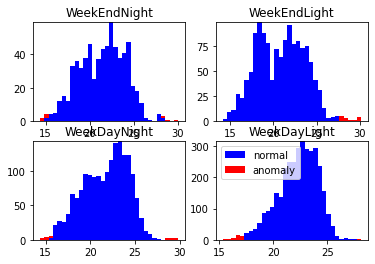

In [ ]:
# plot the temperature repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [ ]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

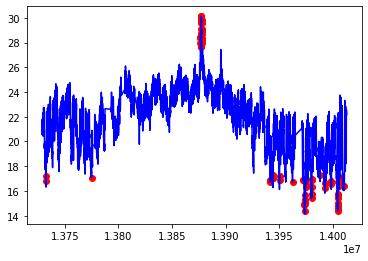

In [ ]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


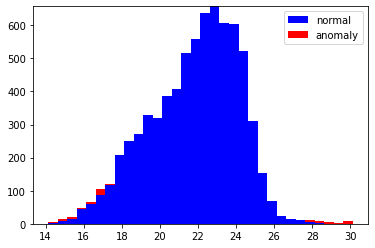

In [ ]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Good detections of extreme values and context separation add some precision to the detection.

## **Isolation Forest**

**Use for collective anomalies (unordered).**

Simple, works well with different data repartition and efficient with high dimention data.

In [ ]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    7194
1      73
Name: anomaly25, dtype: int64


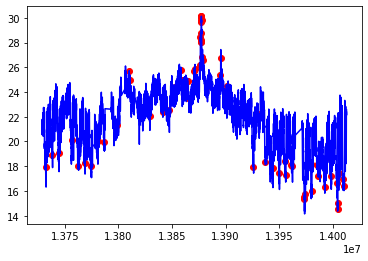

In [ ]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


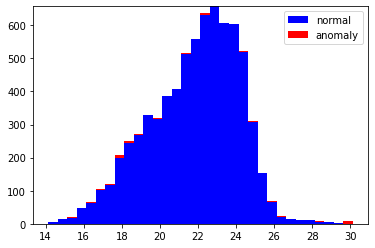

In [ ]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

# **Extra**

## **LSTM Model**

In [ ]:
#Preparing the data for LSTM model
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

In [ ]:
#Important parameters and training/Test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

In [ ]:
#Training data
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut  ][0].values

In [ ]:
#Test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values

In [ ]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)


In [ ]:
#Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

In [ ]:
#Shape of the data
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [ ]:
#Building the model
model = Sequential()

model.add(LSTM(1, input_dim=x_train.shape[-1], return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.03275918960571289


In [ ]:
model.fit(x_train, y_train, batch_size=3028, epochs=50, validation_split=0.1)

Epoch 1/50
2/2 [==============================] - 12s 3s/step - loss: 0.6633 - val_loss: 1.4768
Epoch 2/50
2/2 [==============================] - 3s 1s/step - loss: 0.4762 - val_loss: 1.3925
Epoch 3/50
2/2 [==============================] - 3s 1s/step - loss: 0.4501 - val_loss: 1.3208
Epoch 4/50
2/2 [==============================] - 2s 1s/step - loss: 0.4412 - val_loss: 1.1798
Epoch 5/50
2/2 [==============================] - 3s 1s/step - loss: 0.3819 - val_loss: 0.9199
Epoch 6/50
2/2 [==============================] - 3s 1s/step - loss: 0.4122 - val_loss: 0.9233
Epoch 7/50
2/2 [==============================] - 3s 1s/step - loss: 0.3340 - val_loss: 0.7385
Epoch 8/50
2/2 [==============================] - 3s 1s/step - loss: 0.3262 - val_loss: 0.9350
Epoch 9/50
2/2 [==============================] - 3s 1s/step - loss: 0.3313 - val_loss: 0.5602
Epoch 10/50
2/2 [==============================] - 3s 1s/step - loss: 0.2885 - val_loss: 0.5220
Epoch 11/50
2/2 [==============================]

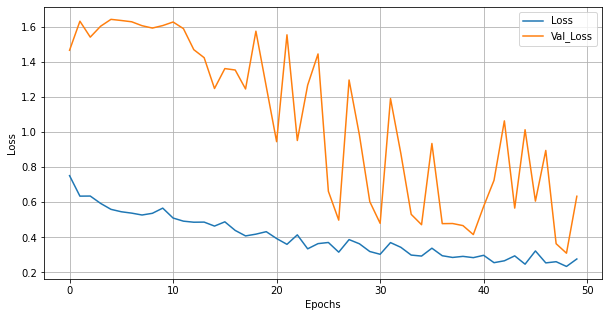

In [ ]:
#Visualizing training and validaton loss
plt.figure(figsize = (10, 5))
plt.plot(model.history.history['loss'], label = 'Loss')
plt.plot(model.history.history['val_loss'], Label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

In [ ]:
#creating the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

32/32 [==============================] - 1s 16ms/step


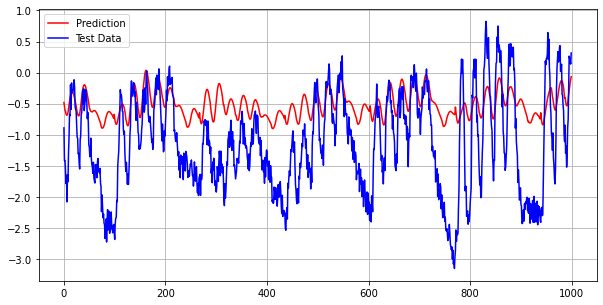

In [ ]:
#Plotting the prediction and the reality (for the test data)
plt.figure(figsize = (10, 5))
plt.plot(p,color='red', label='Prediction')
plt.plot(y_test,color='blue', label='Test Data')
plt.legend(loc='upper left')
plt.grid()
plt.legend()

In [ ]:
#Pick the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
#Data with anomaly label
test = (diff >= threshold).astype(int)
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


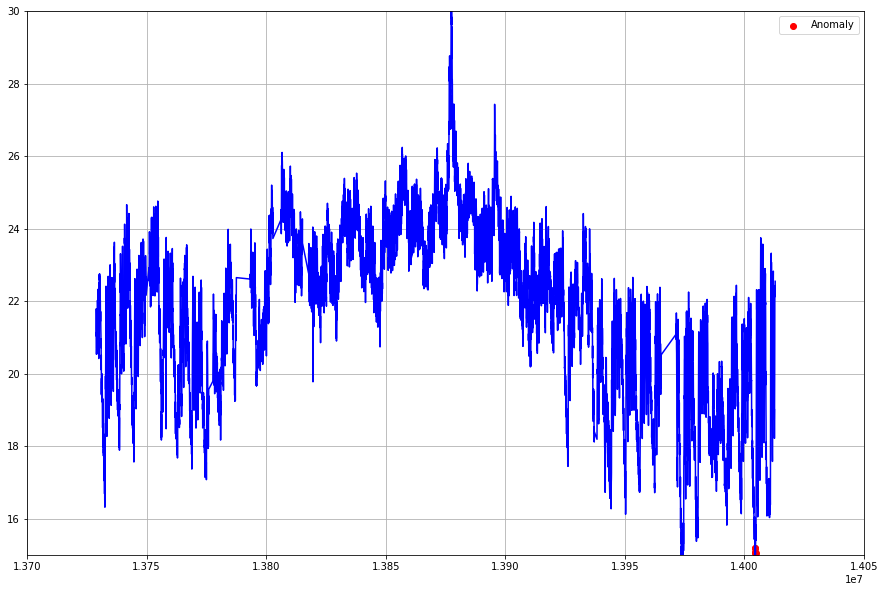

In [ ]:
#Visualizing anomalies (Red Dots)
plt.figure(figsize=(15,10))
a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly
plt.plot(df['time_epoch'], df['value'], color='blue')
plt.scatter(a['time_epoch'],a['value'], color='red', label = 'Anomaly')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.grid()
plt.legend()

As we can see in the above picture, the anomalies are visualized as red points. All the above steps can be repeated multiple times to visualize the anomalies by tuning the hyperparameters. If we find the same visualization at the end, then we can end-up with these anomalies. 